In [1]:
import torch
import sys
import os
sys.path.append('../vega/')
import vega
import scanpy as sc
import numpy as np
import pandas as pd
torch.manual_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib
path_to_save = '../paper/figures/gbm_vega/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5

In [2]:
model = vega.VEGA.load('../trained_models/gbm_vega/')
print(model)

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 6061, dropout_rate:0.5, z_dropout:0.5, beta:5e-05, positive_decoder:True
Model is trained: True


In [3]:
model.adata.obsm['X_vega'] = model.to_latent(return_mean=True)

In [4]:
# tSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=250, random_state=42)
tsne_coord = tsne.fit_transform(model.adata.obsm['X_vega'])

In [5]:
tsne_df = pd.DataFrame({'tSNE-1':tsne_coord[:,0], 'tSNE-2':tsne_coord[:,1],
                        'Cell Type':[i[:-2] if not i.isalpha() else i for i in model.adata.obs['Cell Type']],
                       'Patient':model.adata.obs['Sample.name']})

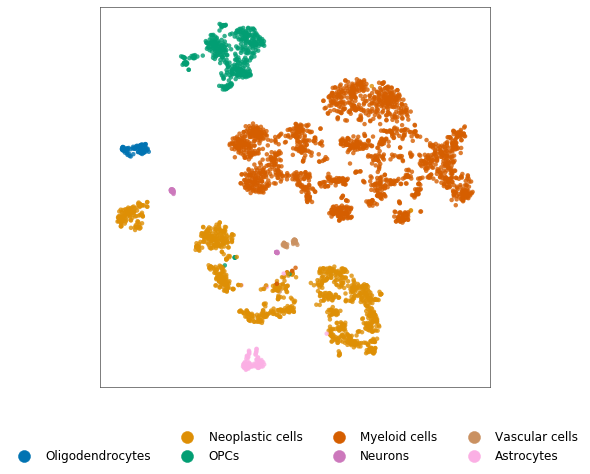

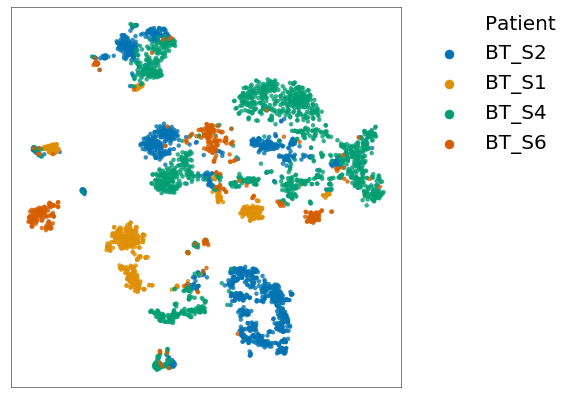

In [15]:
import seaborn as sns
sns.set_palette('colorblind')
fig, ax = plt.subplots(figsize=[7,7])
sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Cell Type', data=tsne_df, linewidth=0, alpha=0.8, s=20, ax=ax, rasterized=True)
l = ax.legend(title='', title_fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, borderaxespad=0., fontsize=12, frameon=False, markerscale=2)
l.texts[0].set_text("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig(path_to_save+'tsne_ct.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


fig, ax = plt.subplots(figsize=[7,7])
sns.scatterplot(x='tSNE-1', y='tSNE-2', hue='Patient', data=tsne_df, linewidth=0, alpha=0.8, s=20, ax=ax, rasterized=True)
ax.legend(title_fontsize=20,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig(path_to_save+'tsne_patient.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [16]:
pathway_encoded_df = pd.DataFrame(data=model.adata.obsm['X_vega'],
                                  index=model.adata.obs.index.tolist(),
                                  columns=model.adata.uns['_vega']['gmv_names'])

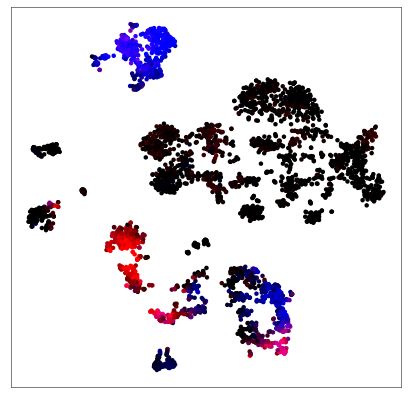

In [18]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib import patches
fig, ax = plt.subplots(figsize=[7,7])
normalizer=Normalize(0,5)
cmap_stat = LinearSegmentedColormap.from_list('mycmap', ['black', 'red'])
cmap_olig = LinearSegmentedColormap.from_list('mycmap', ['black', 'blue'])
mapper_b = cm.ScalarMappable(norm=normalizer, cmap=cmap_olig)
mapper_r = cm.ScalarMappable(norm=normalizer, cmap=cmap_stat) 

rgb_olig = mapper_b.to_rgba(pathway_encoded_df['OLIG2'])
rgb_stat = mapper_r.to_rgba(pathway_encoded_df['STAT3'])
rgb_all = np.maximum(rgb_olig, rgb_stat)
scat = ax.scatter(tsne_df['tSNE-1'], tsne_df['tSNE-2'], linewidth=0,
                  alpha=1, s=20, norm=normalizer, c = rgb_all, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
# cbar_olig = fig.colorbar(mapper_b,fraction=0.05, pad=0.05)
# cbar_stat = fig.colorbar(mapper_r, fraction=0.05, pad=0.05)
# cbar_olig.ax.set_title('OLIG2', fontsize=15)
# cbar_stat.ax.set_title('STAT3', fontsize=15)
# for t in cbar_olig.ax.get_yticklabels():
#      t.set_fontsize(15)
# for t in cbar_stat.ax.get_yticklabels():
#      t.set_fontsize(15)
        
#plt.savefig(path_to_save+'tsne_olig_stat.pdf', format='pdf', dpi=300, bbox_inches='tight')

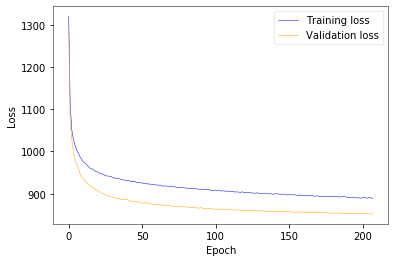

In [9]:
vega.plotting.loss(model)